# MiMICRI demo

This notebook is a demonstration of the [ACM FAccT 2024 paper](https://arxiv.org/abs/2404.16174) titled:

`MiMICRI: Towards Domain-centered Counterfactual Explanations of Cardiovascular Image Classification Models`

mimicri is a python library of interactive visualizations for segmentation-based counterfactual generation, designed to work with the JupyterLab computational environment.

In [1]:
import nibabel as nib
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
segMap = {1: "LV Cavity", 2: "LV Myocardium", 3: "RV Cavity"}

In [25]:
# To protect patient privacy, we provide only synthetic demographic data here to demonstrate MiMICRI

demographics = [{"eid":"1", "BMI":"20", "age":"32"}, {"eid":"2", "BMI":"17", "age":"17"}]

In [15]:
# If you have a demographics json file, replace {DEMOGRAPHICS_FILEPATH} in the following with the path to your file

# with open('{DEMOGRAPHICS_FILEPATH}', "r") as file:
#     demographics = json.loads(file.read())

In [16]:
demographics[0]

{'eid': '1', 'BMI': '20', 'age': '32'}

In [20]:
path = "./demo_image/"

In [21]:
data = []

# Get image and segmentation filepath for each patient
for i in range(len(demographics)):
    patient = demographics[i]
    patient_id = patient["eid"]
    imageFile = path + patient_id + "/sa.nii.gz"
    segmentFile = path + patient_id + "/seg_sa.nii.gz"
    
    patient["image"] = imageFile
    patient["segments"] = segmentFile
    
    data.append(patient)

In [22]:
data[0]

{'eid': '1',
 'BMI': '20',
 'age': '32',
 'image': './demo_image/1/sa.nii.gz',
 'segments': './demo_image/1/seg_sa.nii.gz'}

### VideoRender

If your MRIs are video files, you can view a single MRI using the mimicri VideoRender module

In [23]:
def singleVideoReader(filePath):
    fileData = nib.load(filePath).get_fdata()[..., 0, :]
    fileData = np.moveaxis(fileData, [0, 1, 2], [1, 2, 0])
            
    return fileData.tolist()

In [24]:
from mimicri import VideoRender

VideoRender(data[0]["image"], data[0]["segments"], singleVideoReader)

VideoRender(component='VideoRender', props={'images': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0…

### MultiFrame

To view multiple video MRI files at once, you can use the mimicri VideoMulti module

In [26]:
import skimage.measure

In [27]:
def multiVideoReader(filePath):
    fileData = nib.load(filePath).get_fdata()[..., 0, :]
                    
    return fileData

In [28]:
from mimicri import VideoMulti

In [ ]:
# Uncomment the following to view multiple video files
# VideoMulti([d["image"] for d in data[0:20]], [d["segments"] for d in data[0:20]], multiVideoReader)

### Selector

The mimicri selector module allows you to view target and source MRIs for recombined MRI generation.

In the top panel, you can select segments to replace. In the bottom panel, you can filter for source files based on demographic data. In this example, we only have 1 demo file that can be used as a source, so the demographic filters will not be particularly interesting. In a real data set with more samples and a wider distribution of demographic data, this can help you select which MRIs to use as the source for recombined MRI generation.

Both panels can be resized by dragging the dividing line.

In [34]:
# Uncomment to read nifti as single image
def imgReader(filePath):
    fileData = nib.load(filePath).get_fdata()[..., 8, 0]
    return fileData

# Uncomment to read nifti as video
# def videoReader(filePath):
#     fileData = nib.load(filePath).get_fdata()[..., 8, :]
#     return fileData

In [35]:
target = data[0]
source = data[1:]

In [36]:
target

{'eid': '1',
 'BMI': '20',
 'age': '32',
 'image': './demo_image/1/sa.nii.gz',
 'segments': './demo_image/1/seg_sa.nii.gz'}

In [37]:
from mimicri import Selector

In [38]:
se = Selector(target=[target], source=source, imgReader=imgReader, segMap=segMap, _index="eid")
se

setting source...


Selector(component='Selector', props={'mainImage': {'images': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, …

### Generate Recombined MRIs

After selecting the segments and source MRIs, you can view your selections here. Note that your selections will only be reflected after some interaction with the Selector module.

In [39]:
len(se.subset)

1

In [41]:
se.segments

[3, 1, 2]

Finally, we provide the `.morphmix()` function to generate the recombined MRIs.
Replace the outfolder value to change the destination folder where the recombined MRIs will be saved.

In [42]:
se.morphmix(outfolder="./recombined/")

View your newly recombined MRI using matplotlib. Or, if your recombined MRI is a video file, you can also use the VideoRender module as shown above.

In [43]:
fileData = nib.load("./recombined/img/2_1.nii.gz").get_fdata()
fileData.shape

(210, 208)

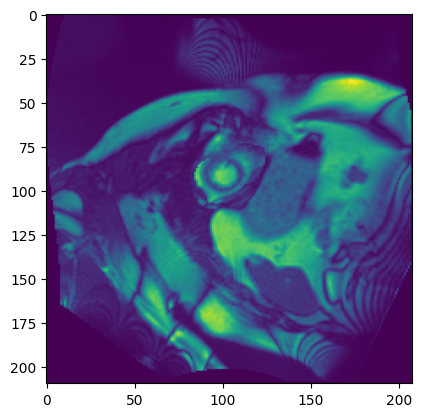

In [44]:
imgplot = plt.imshow(fileData)
plt.show()

### Counterfactual Inspection

Note that so far, what we have produced are recombined MRIs. However, they are not necessarily counterfactuals. For the recombined MRI to be a counterfactual, some predictive model needs to output a different predicted label for the recombined MRI compared to the target MRI.

You will need to train your own predictive model for this step. For more details, you can refer to [our paper here](https://arxiv.org/abs/2404.16174).